In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import sys
from collections import defaultdict
from collections import Counter
from collections import OrderedDict
import numpy as np

sys.path.append('../binf_scripts')

import sequence


def display_col_tags(ec_num:str, col_name: str):
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    counts = df[[col_name]].value_counts()
    print(counts)

    

In [2]:
ec_top_10 = ['2_7_11_1', '2_7_13_3', '2_7_10_2', '2_7_10_1', '1_14_99_39', '2_5_1_18', '3_2_1_8', '3_5_2_6', '1_15_1_1', '4_1_1_39']


# Save EC info into set and calculate Jaccard similarity 

Jaccard similarity = (A & B) / (A or B)


# Used to check how many entries contain data of interest 

In [11]:

def calculate_annots(ec_num ,col_name):
 
    print(col_name)

    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    num_rows = df.shape[0]

    if col_name in df.columns:
            annot_count = df[col_name].dropna().shape[0]
            percent_annot = round((annot_count/num_rows) * 100, 2)
            print(f"{ec_num} {col_name}: {percent_annot}% of entries annotated")
        
    else:
        print(f"{ec_num} does not have {col_name} column")

    print("\n")

    
def filtered_annots(ec_num:str, filtered_entries: list, enzyme_prop: str):

    for key in filtered_entries.keys():
      
        df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")
    
        df = df.loc[df['Entry'].isin(filtered_entries.get(key))]

        num_rows = df.shape[0]

        if enzyme_prop in df.columns:
                annot_count = df[enzyme_prop].dropna().shape[0]
                percent_annot = round((annot_count/num_rows) * 100, 2)
                print(f"{ec_num}: {enzyme_prop}: {percent_annot}% of entries annotated in {key}")



# Sorting interpro
- methods below work for both interpro and SMART tags

In [4]:

#enter ec num and threshold to define a cutoff for similarity when grouping tags 
def remove_outliers(ec_num: str, data_col:str, entry_limit = 0):
    """
    Reads in all seqs from an ec_group, 
    
    rm_outliers: condition that will remove any groups 
    that only have one entry in them 
    
    data_col (str): The particular data column being compared for the sequences. 
    e.g. Cross_reference_InterPro or Cross_reference_SMART 
    
    entry_limit: the minimum number of entries a tag must have to be included 
    """

    enzyme_cols = ['Entry', data_col]

    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    #will count each appearance of particular interpro class 
    counters = defaultdict(int)
    df = df[enzyme_cols]
    
    #draft before removing na values 
    #interpro_counts = df[data_col].value_counts()
    
    interpro_counts = df[data_col].dropna().value_counts()
    
    filtered_interpro = dict()
    
    #filter out distant entries 

    for key, value in interpro_counts.items():
        if value > entry_limit:
            filtered_interpro[key] = value
    
       
    return filtered_interpro 
    
    
def calc_jaccard_matrix(ec_num: str, threshold: float, filtered_counts, data_col):
  
    enzyme_cols = ['Entry', data_col]

    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    #will count each appearance of particular interpro class 
    counters = defaultdict(int)

    #splits interpro tags and creates a set to allow comparison of elements   
    tag_list = [set(tag[:-1].split(';')) for tag in filtered_counts.keys()]
    
    #initialise the similarity matrix
    distmat = np.zeros((len(tag_list), len(tag_list)))

    #cacluate JS at for each tag pair 
    for i in range(len(tag_list)):
        for j in range(i+1, len(tag_list)):
            
            A = tag_list[i]
            B = tag_list[j]

           
            intersection = A.intersection(B)

            union = A.union(B)
            
            #calculate Jaccard similarity 
            similarity = len(intersection)/len(union)
            
            #updates matrix 
            distmat[i, j] = distmat[j, i] = similarity 
    
    #record how many sequences have each type of IP tag, use for axis ticks 
    interpro_tag_counts = [str(value) + ' - '  \
                           + str(key)for key, value in filtered_counts.items()]
    
    #plot heatmat for reference 
    fig, ax = plt.subplots()
    plt.imshow(distmat, plt.cm.inferno, interpolation='nearest')
    plt.colorbar()
    plt.yticks(np.arange(len(tag_list)), interpro_tag_counts)
    plt.xticks(np.arange(len(tag_list)), [x for x in filtered_counts.keys()], rotation=90)
    plt.subplots_adjust(bottom=0.35)
    plt.title(f'{ec_num}: {data_col} Jaccard Similarity')
    plt.show()
    
    #IP names stored here so that loop below can reference name with matrix indices 
    interpro_names = [key for key in filtered_counts.keys()]
    
    #groupings of IP tags that are simililar will be stored here 
    similar_groups = []
    
    #iterate through each row in the matrix 
    for i in range(len(interpro_names)):
      
        #current row being compared to columns 
        key_group = str(interpro_names[i])
        
        #include group being compared as diagnonals will be zero 
        tag_group = [key_group]
        
        #compare every row to each column 
        for j in range(len(interpro_names)):
            
            #every column above or equal to threshold gets recorded 
            if distmat[i, j] >= threshold:
                tag_group.append(interpro_names[j])  
        
        similar_groups.append(tag_group)
        
    return similar_groups



def display_families(ec_num, similar_groups, index, data_col: str):
    """
    similar_groups: list containing groupings of tags that are similar to each other 
    
    index: user specifies which group they would like to see on a graph 
    
    """
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    enzyme_cols = ['Entry', 'Protein_families', data_col]
    
    #stores which group of tags user wants to look at 
    ip_ref = similar_groups[index]

    #will count each appearance of particular family from the IP groups  
    counters = defaultdict(int)

    df = df[enzyme_cols]
 
    #filters data frame to only include entries with tags in the similarity group 
    df = df.loc[df[data_col].isin(ip_ref)]

    #record appearances of each family 
    family_counts = df['Protein_families'].value_counts()       
        
    #place these values in a dict so that it's easier to plot below 
    for index, value in family_counts.items():
        counters[index] = value 
    
    #plot a histogram of family counts
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(counters.keys(), counters.values())
    plt.xticks(rotation='vertical')
    ax.set_xlabel('Family')
    ax.set_ylabel('# of entries')
    ax.set_title(f'Different families in {ec_num} using {data_col}')
    plt.show()
    
def grab_seqs(ec_num: str, similar_groups: list, col_name: str, index: int):
    
    """
    Grabs all sequences that have been put together in a group
    that is deemed to be similar to each other based on the calc_jaccard_matrix 
    method 
    
    similar_groups (list): uses the output from calc_jaccard_matrix to grab all entries 
    that have tags in that group 
    """
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")
    
    df = df.loc[df[col_name].isin(similar_groups[index])]

    df = df['Entry']
        
    df = df.values.tolist() 

    return df


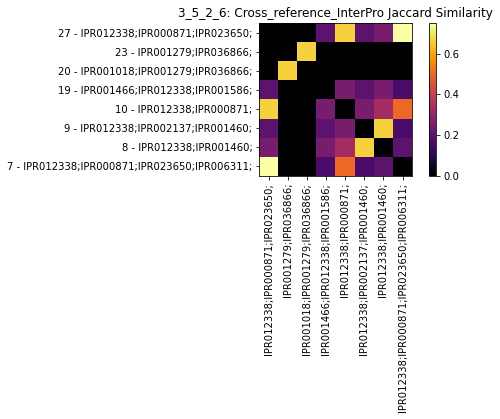

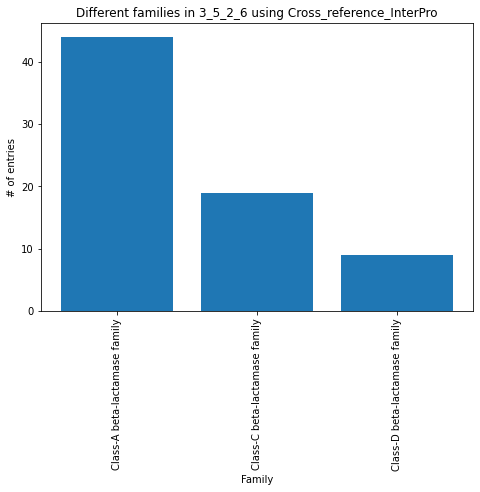

In [6]:

filtered_list = remove_outliers('3_5_2_6', 'Cross_reference_InterPro', 5)

test = calc_jaccard_matrix('3_5_2_6', 0.2, filtered_list, 'Cross_reference_InterPro')

display_families('3_5_2_6', test, 0, 'Cross_reference_InterPro')

target_IP_seqs = set(grab_seqs('3_5_2_6', test, 'Cross_reference_InterPro', 0))


# Need to test method on following data cols 


- Cross_reference_eggNOG - 39.01% contain anont: only one entry per eggNOG tag 

- Cross_reference_OMA 
- Cross_reference_OrthoDB - https://academic.oup.com/nar/article/49/D1/D389/5983625?login=true
The concept of orthology is inherently hierarchical, as each phylogenetic clade or subclade of species has a distinct common ancestor, leading to more finely-resolved orthologs for more closely related species. OrthoDB has explicitly emphasized this since its inception 

- Cross_reference_SMART 
- Cross_reference_SUPFAM - created in 2004, doesn't look like its been maintained or updated very often 

# Gene3D filtering

- Cross_reference_Gene3D - 80.8%: annot 


In [5]:
def display_families_Gene3D(ec_num: str, gene_tag:str):
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    enzyme_cols = ['Entry', 'Protein_families', 'Cross_reference_Gene3D']
    
    #will count each appearance of particular family  
    counters = defaultdict(int)

    df = df[enzyme_cols]
    
    #filters data frame to only include entries with tags matching the HOGENOM tag 
    filtered_df = df.loc[(df.Cross_reference_Gene3D == gene_tag)]
  
    #record appearances of each family #draft
    
    family_counts = filtered_df['Protein_families'].value_counts()

    
    #place these values in a dict so that it's easier to plot below 
    for index, value in family_counts.items():
        counters[index] = value 
    
    #plot a histogram of family counts
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(counters.keys(), counters.values())
    plt.xticks(rotation='vertical')
    ax.set_xlabel('Family')
    ax.set_ylabel('# of entries')
    ax.set_title(f'Different families in {ec_num} using {gene_tag}')
    plt.show()
    
    
def grab_seqs_G3D(ec_num: str, G3D_tag: str):
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")
    
    df = df.loc[df.Cross_reference_Gene3D == G3D_tag]

    df = df['Entry']
        
    df = df.values.tolist()     
    
    return df
    

    
display_col_tags('3_5_2_6', 'Cross_reference_Gene3D')

Cross_reference_Gene3D
3.40.710.10;              82
3.60.15.10;               45
dtype: int64


Series([], Name: Protein_families, dtype: int64)


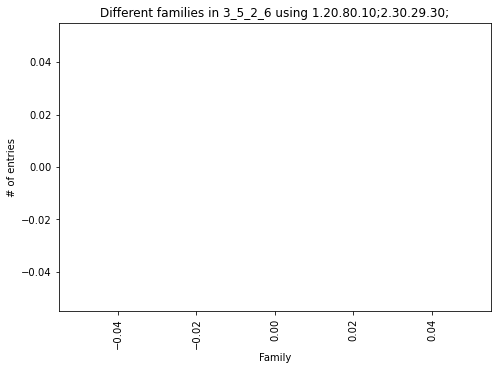

      Entry                                   Protein_families
0    Q9KVZ2  Metallo-beta-lactamase superfamily, Class-B be...
1    A0EL75                      Class-A beta-lactamase family
2    Q93F76                      Class-A beta-lactamase family
3    Q7BEB3                      Class-A beta-lactamase family
4    Q51578                      Class-C beta-lactamase family
..      ...                                                ...
124  Q6JP75                      Class-A beta-lactamase family
125  Q6PL88                                                NaN
126  Q6VCW0                      Class-D beta-lactamase family
127  Q7WZ37                      Class-C beta-lactamase family
128  P0AD64                      Class-A beta-lactamase family

[129 rows x 2 columns]


In [8]:
display_families_Gene3D('3_5_2_6', '1.20.80.10;2.30.29.30;')


target_G3D = set(grab_seqs_G3D('3_5_2_6', '1.20.80.10;2.30.29.30;'))



# OrthoDB

In [6]:
def display_families_Ortho(ec_num: str, gene_tag:str):
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    enzyme_cols = ['Entry', 'Protein_families', 'Cross_reference_OrthoDB']
    
    #will count each appearance of particular family  
    counters = defaultdict(int)

    df = df[enzyme_cols]
    
    #filters data frame to only include entries with tags matching the HOGENOM tag 
    filtered_df = df.loc[(df.Cross_reference_OrthoDB == gene_tag)]
  
    #record appearances of each family #draft
    
    family_counts = filtered_df['Protein_families'].value_counts()

    
    #place these values in a dict so that it's easier to plot below 
    for index, value in family_counts.items():
        counters[index] = value 
    
    #plot a histogram of family counts
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(counters.keys(), counters.values())
    plt.xticks(rotation='vertical')
    ax.set_xlabel('Family')
    ax.set_ylabel('# of entries')
    ax.set_title(f'Different families in {ec_num} using {gene_tag}')
    plt.show()
    
def grab_seqs_ortho(ec_num: str, ortho_tag: str):
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")
    
    df = df.loc[df.Cross_reference_OrthoDB == ortho_tag]

    df = df['Entry']
        
    df = df.values.tolist()     
    
    return df    


Cross_reference_OrthoDB
539311at2759;              24
776697at2759;              13
390511at2759;              12
58906at2759;               10
243095at2759;               8
1047190at2759;              8
43729at2759;                8
491765at2759;               6
796831at2759;               6
993493at2759;               5
219904at2759;               5
988822at2759;               3
1063695at2759;              3
346354at2759;               2
556386at2759;               2
684563at2759;               2
1299087at2759;              1
1155741at2759;              1
597979at2759;               1
145621at2759;               1
740146at2759;               1
769579at2759;               1
1100558at2759;              1
182823at2759;               1
826997at2759;               1
827472at2759;               1
426838at2759;               1
1008736at2759;              1
dtype: int64


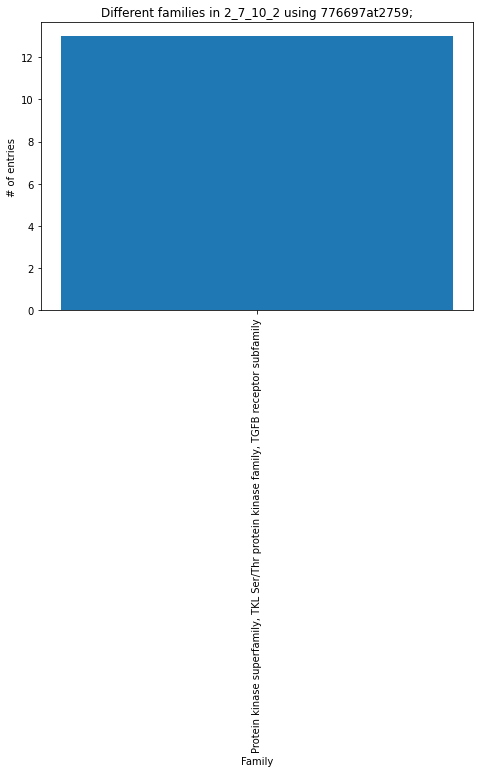

In [31]:
display_col_tags('2_7_10_2', 'Cross_reference_OrthoDB')

display_families_Ortho('2_7_10_2',  '776697at2759;')

# SMART Filtering 

In [7]:
def display_families_SMART(ec_num: str, smart_tag:str):
    """
    Can be used to look at single tags and the distribution of famlies within 
    these groups. 
    """
    
    df = pd.read_csv(f"../workflows/{ec_num}/csv/{ec_num}_uniprot.csv")

    enzyme_cols = ['Entry', 'Protein_families', 'Cross_reference_SMART']
    
    #will count each appearance of particular family  
    counters = defaultdict(int)

    df = df[enzyme_cols]

    #filters data frame to only include entries with tags matching the HOGENOM tag 
    filtered_df = df.loc[(df['Cross_reference_SMART'] == smart_tag)]
  

    #record appearances of each family #draft
    family_counts = filtered_df['Protein_families'].value_counts()
               
    #place these values in a dict so that it's easier to plot below 
    for index, value in family_counts.items():
        counters[index] = value 
    
    #plot a histogram of family counts
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(counters.keys(), counters.values())
    plt.xticks(rotation='vertical')
    ax.set_xlabel('Family')
    ax.set_ylabel('# of entries')
    ax.set_title(f'Different families in {ec_num} using {smart_tag}')
    plt.show()

    
display_col_tags('2_7_10_2', 'Cross_reference_SMART')

Cross_reference_SMART                   
SM00252;SM00326;SM00219;                    60
SM00220;                                    30
SM00467;SM00220;                            17
SM00295;SM00252;SM00219;                    12
SM00295;SM00219;                            11
SM00109;SM00455;SM00220;                     9
SM00252;SM00219;                             8
SM00055;SM00252;SM00219;                     8
SM00107;SM00233;SM00252;SM00326;SM00219;     6
SM00808;SM00252;SM00326;SM00219;             5
SM00132;SM00228;                             3
SM00248;SM00252;SM00219;                     2
SM00248;                                     2
SM00219;                                     2
SM00369;SM00220;                             2
SM00005;SM00220;                             2
SM00268;SM00252;SM00219;                     1
SM00108;SM00473;SM00220;                     1
SM00326;SM00219;                             1
SM00409;SM00408;SM00219;                     1
SM00467;           

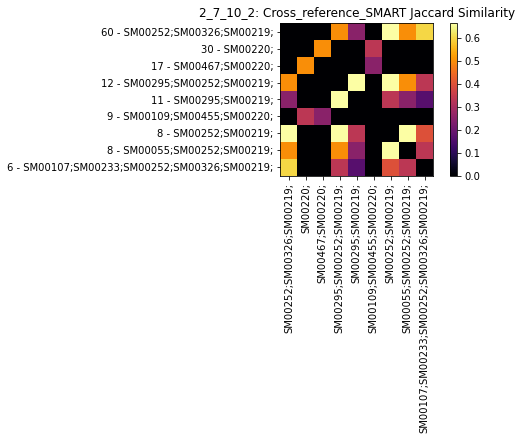

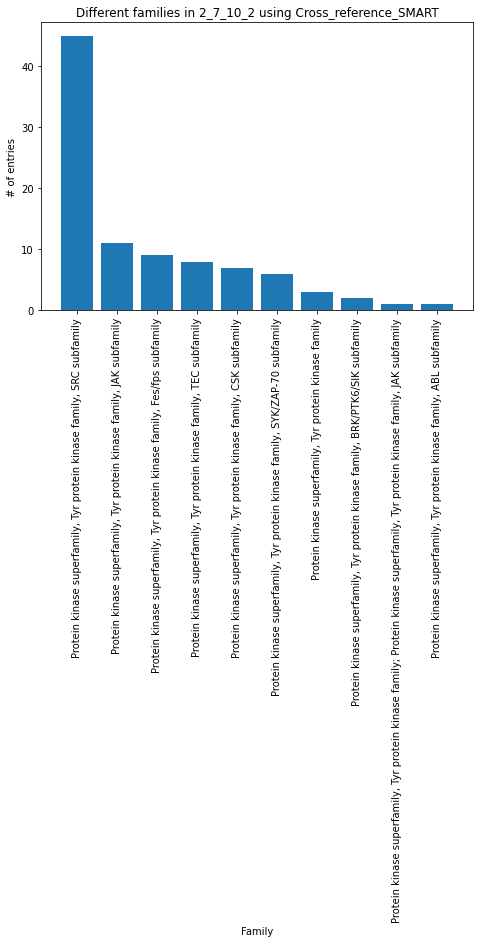

In [11]:
#display_families_SMART('2_7_10_2', 'SM00252;SM00326;SM00219;')

filtered_list = remove_outliers('2_7_10_2', 'Cross_reference_SMART', 5)

test = calc_jaccard_matrix('2_7_10_2', 0.5, filtered_list, 'Cross_reference_SMART')

display_families('2_7_10_2', test, 0, 'Cross_reference_SMART')

smart_target_seqs = grab_seqs('2_7_10_2', test, 'Cross_reference_SMART', 0)
    

# Combining different filtering methods 

In [37]:
def generate_filtered_entries(ec_num: str, threshold: int, enzyme_prop: str ,entry_limit = 0):
    """
    ec_num (str): string version of enzyme number 
    
    threshold (int): Cutoff between 0 and 1 for how similar SMART & InterPro tags must 
    be to each other to be classed as similar
    
    enzyme_prop (str): enzyme property that user wants to have annotated, e.g. BRENDA_KM
    
    entry_limit: the minimum number of entries a interpro or SMART tag must have to be included 
    in the Jaccard Similarity matrix. Used to help remove outliers
    
    """
    
    #will store a list of entries for each type of filtering used 
    filtering_stages = {}
    
    #show how many entries contain the chosen enzyme property within the EC group 
    calculate_annots(ec_num, enzyme_prop)  
    
    #remove groups below the minimum number of entries within the EC group 
    filtered_smart = remove_outliers(ec_num, 'Cross_reference_SMART', entry_limit)

    #create jaccard matrix from filtered list 
    smart_matrix = calc_jaccard_matrix(ec_num, threshold, filtered_smart, 'Cross_reference_SMART')

    #same as above except with InterPro 
    filtered_ip = remove_outliers(ec_num, 'Cross_reference_InterPro', entry_limit)

    ip_matrix = calc_jaccard_matrix(ec_num, threshold, filtered_ip, 'Cross_reference_InterPro')     
        
    
    filtering_loop = True 
    
    #next, compare the distributions of families until user deems them to be similar enough 
    while filtering_loop:
        
        choose_smart_tag = int(input('Choose a SMART row to grab entries from: '))
        
        choose_ip_tag = int(input('Choose a InterPro row to grab entries from: '))
        
        #display SMART entries of chosen tags and groups that are similar 
        if len(smart_matrix) > 0:
            display_families(ec_num, smart_matrix, choose_smart_tag, 'Cross_reference_SMART')
        
        #display interpro entries of chosen tags and groups that are similar 
        display_families(ec_num, ip_matrix, choose_ip_tag, 'Cross_reference_InterPro')
        
        end_comp = input('Happy with selection(Y/N): ')
        
        if end_comp.upper() == "Y":
            filtering_loop = False 
        
    #Once user is happy with selections, record which entries are included 
    target_ip = list(grab_seqs(ec_num, ip_matrix, 'Cross_reference_InterPro', choose_ip_tag))
    
    filtering_stages['IP'] = target_ip
    
    print(f'Number of sequences after IP filtering = {len(target_ip)}')
    if len(smart_matrix) > 0:
        target_smart = list(grab_seqs(ec_num, smart_matrix, 'Cross_reference_SMART', choose_smart_tag))

        filtering_stages['SMART'] = target_smart

    
    if len(smart_matrix) > 0:
        print(f'Number of sequences after SMART filtering = {len(target_smart)}')
    
    #next create a list of relevent entries based on Gene3D tags 
    
    compare_gene3D = False 
    
    #display how many entries have Gene3D annot in the EC group 
    calculate_annots(ec_num, 'Cross_reference_Gene3D')  
    
    check_3d = input('Compare entries to gene3D filtering? (Y/N): ')
    
    if check_3d.upper() == "Y":
        compare_gene3D = True 
        
    while compare_gene3D: 
        
        #show user what groups are within Gene3D
        display_col_tags(ec_num, 'Cross_reference_Gene3D')

        gene_tag = input('Enter a Gene3D tag: ')
        
        #Show protein families within the chosen G3D tag 
        display_families_Gene3D(ec_num, gene_tag)

        check_again = input('Would you like to choose another group? (Y/N): ')
        
        if check_again.upper() == 'N':

            compare_gene3D = False
            
            #record entries once user is happy with selection based on protein families 
            target_g3d = list(grab_seqs_G3D(ec_num, gene_tag))
            
            filtering_stages['Gene3D'] = target_g3d
            
            print(f'The number of entries in the Gene3D group are {len(target_g3d)} \n')

    #create list of entries based off OrthoDB tags 
    
    compare_ortho_DB = False 
    
    calculate_annots(ec_num, 'Cross_reference_OrthoDB')
    
    check_ortho = input('Compare entries to OrthoDB filtering? (Y/N): ')
    
    if check_ortho.upper() == "Y":
        compare_ortho_DB = True 
    
    while compare_ortho_DB: 

        display_col_tags(ec_num, 'Cross_reference_OrthoDB')

        ortho_tag = input('Enter a OrthoDB tag: ')

        display_families_Ortho(ec_num, ortho_tag)

        check_again = input('Would you like to choose another group? (Y/N): ')

        if check_again.upper() == 'N':

            compare_ortho_DB = False    
    
            target_ortho = list(grab_seqs_ortho(ec_num, ortho_tag))
        
            filtering_stages['Ortho_DB'] = target_ortho

    #display how many entries still contain information for chosen enzyme property 
    filtered_annots(ec_num, filtering_stages, enzyme_prop)
    
    return filtering_stages
  

# Example workflow with EC 3_5_2_6: Beta Lactamase 

BRENDA_KM
3_5_2_6 BRENDA_KM: 55.04% of entries annotated




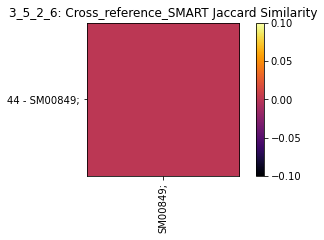

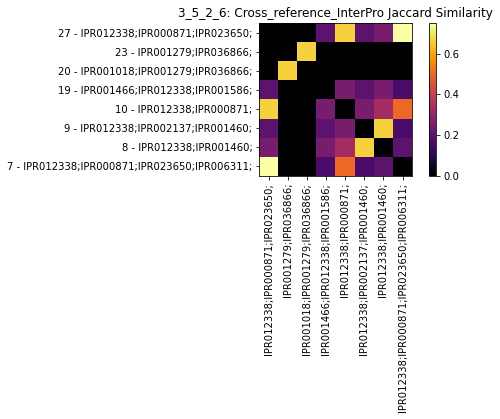

Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 1


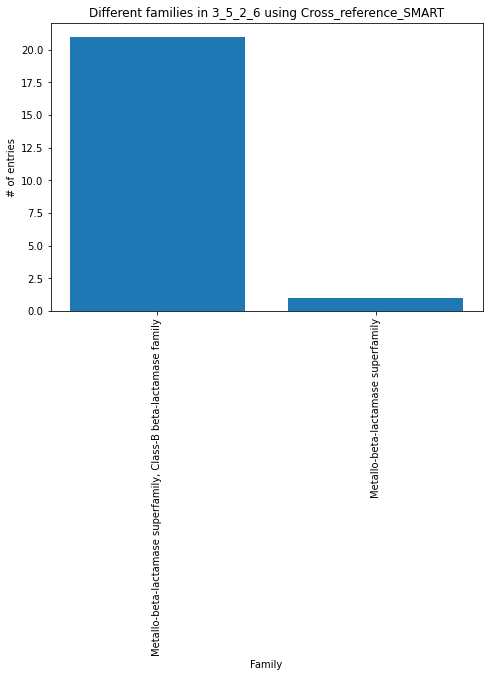

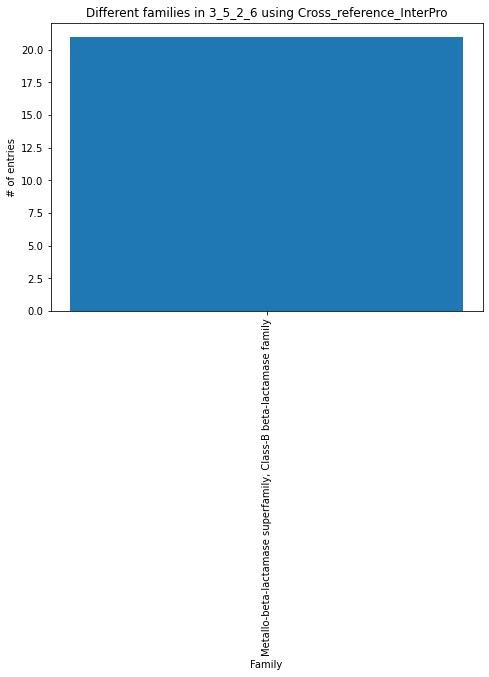

Happy with selection(Y/N): N
Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 0


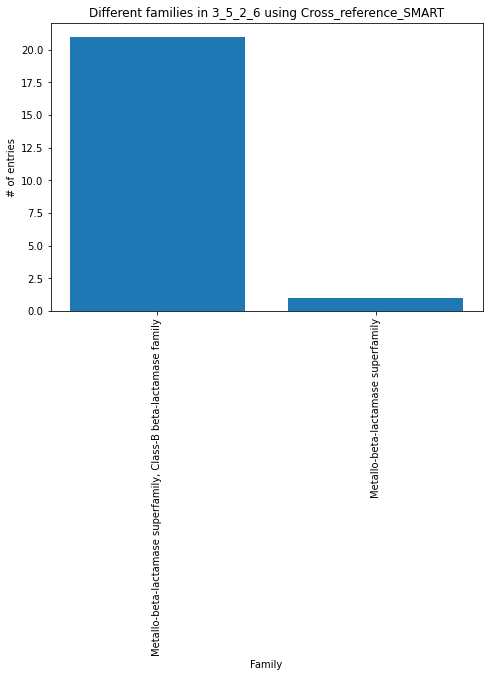

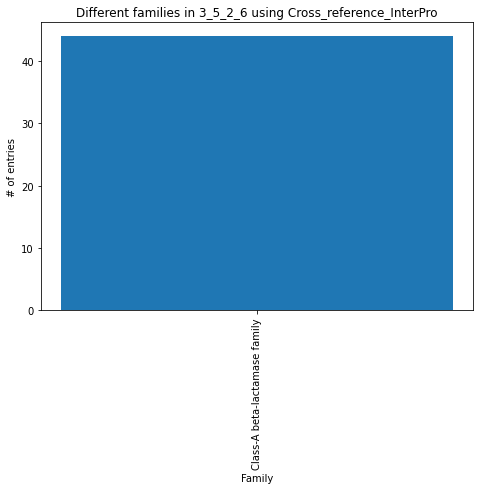

Happy with selection(Y/N): N
Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 0


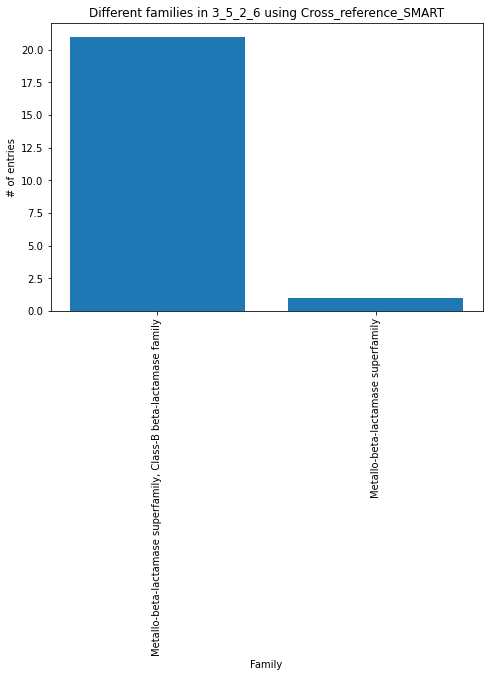

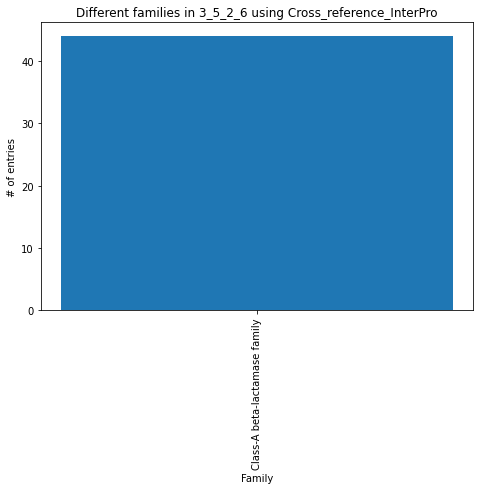

Happy with selection(Y/N): N
Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 1


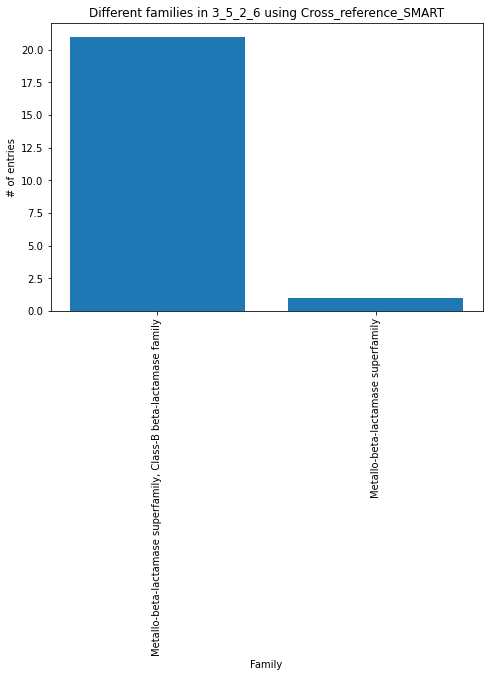

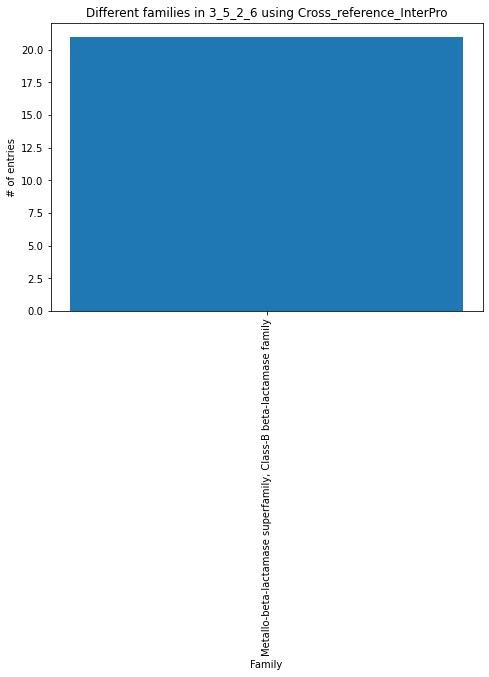

Happy with selection(Y/N): Y
Number of sequences after IP filtering = 43
Number of sequences after SMART filtering = 44
Cross_reference_Gene3D
3_5_2_6 Cross_reference_Gene3D: 98.45% of entries annotated


Compare entries to gene3D filtering? (Y/N): Y
Cross_reference_Gene3D
3.40.710.10;              82
3.60.15.10;               45
dtype: int64
Enter a Gene3D tag: 3.60.15.10;


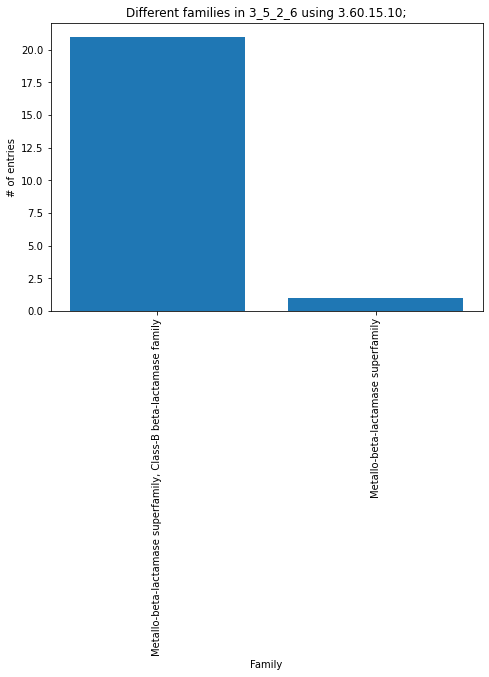

Would you like to choose another group? (Y/N): N
The number of entries in the Gene3D group are 45 

Cross_reference_OrthoDB
3_5_2_6 Cross_reference_OrthoDB: 4.65% of entries annotated


Compare entries to OrthoDB filtering? (Y/N): N
3_5_2_6: BRENDA_KM: 62.79% of entries annotated in IP
3_5_2_6: BRENDA_KM: 61.36% of entries annotated in SMART
3_5_2_6: BRENDA_KM: 62.22% of entries annotated in Gene3D


In [45]:
filtered = generate_filtered_entries('3_5_2_6', 0.5, 'BRENDA_KM', 5)


In [23]:

def calc_total_overlap(filtered_entries: list):

    sets = {key: set(value) for key, value in filtered_entries.items()}

    for key, value in sets.items():
        print(f'{key}: entries = {len(value)}')

    common_vals = [value for value in sets.values()]

    total_overlap = set.intersection(*common_vals)

    print(f'Total overlap between all groups {len(total_overlap)} \n')
    
    return total_overlap 

calc_total_overlap(filtered)


def compare_overlap(filtered_entries: list, group_1, group_2):
    
    g1 = set(filtered_entries[group_1])
    
    g2 = set(filtered_entries[group_2])
    
    overlap = g1.intersection(g2)
    
    print(f'{group_1}: entries = {len(filtered_entries[group_1])}')
    
    print(f'{group_2}: entries = {len(filtered_entries[group_2])}')
    
    
    print(f'Total overlap between {group_1} & {group_2} is {len(overlap)}\n')

    return overlap


compare_overlap(filtered, 'IP', 'SMART')

compare_overlap(filtered, 'IP', 'Gene3D')

compare_overlap(filtered, 'SMART', 'Gene3D')


IP: entries = 43
SMART: entries = 44
Gene3D: entries = 45
Total overlap between all groups 43 

IP: entries = 43
SMART: entries = 44
Total overlap between IP & SMART is 43

IP: entries = 43
Gene3D: entries = 45
Total overlap between IP & Gene3D is 43

SMART: entries = 44
Gene3D: entries = 45
Total overlap between SMART & Gene3D is 44



{'A0A024FRL9',
 'A0A0F6N6D4',
 'A8R403',
 'B1NLE9',
 'C7C422',
 'E6Y3G9',
 'E9RIT0',
 'F2YZ26',
 'H6WET3',
 'H6WZS9',
 'I3VKD5',
 'J7I0S9',
 'M1VE66',
 'O31272',
 'P04190',
 'P25910',
 'P26918',
 'P52699',
 'P52700',
 'Q2HY42',
 'Q4ZE97',
 'Q53BU0',
 'Q53BU1',
 'Q53CM3',
 'Q5U807',
 'Q6D395',
 'Q6JE29',
 'Q79MP6',
 'Q7BJM5',
 'Q7DH52',
 'Q7WYA8',
 'Q840P9',
 'Q8G979',
 'Q8GCU7',
 'Q8GIW8',
 'Q8KRJ3',
 'Q970L2',
 'Q9F629',
 'Q9K2N0',
 'Q9KVZ2',
 'Q9RMI1',
 'Q9XAY4',
 'S5ZIP8',
 'T2A6Y2'}

# Example workflow with EC 4_1_1_39: Rubisco 

BRENDA_KM
4_1_1_39 BRENDA_KM: 71.05% of entries annotated




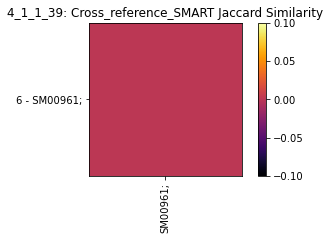

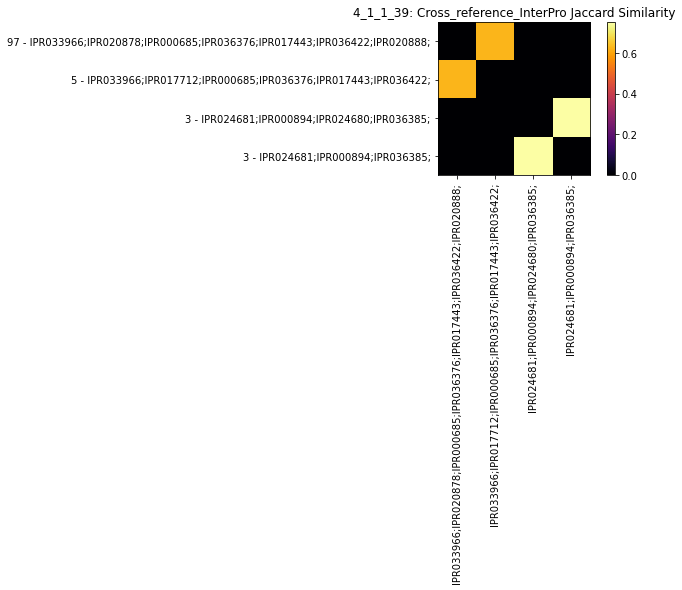

Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 0


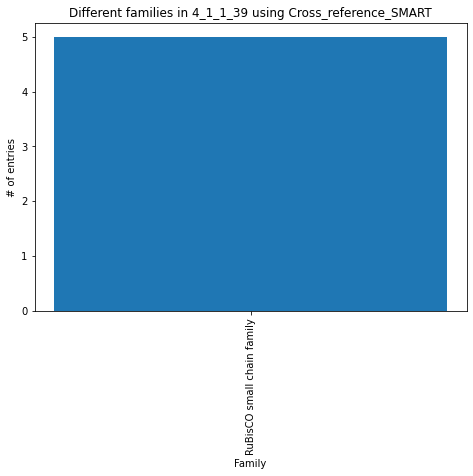

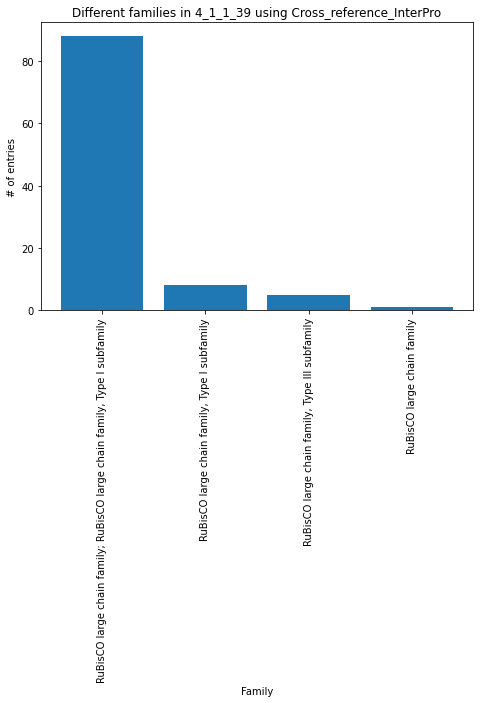

Happy with selection(Y/N): Y
Number of sequences after IP filtering = 102
Number of sequences after SMART filtering = 6
Cross_reference_Gene3D
4_1_1_39 Cross_reference_Gene3D: 99.12% of entries annotated


Compare entries to gene3D filtering? (Y/N): Y
Cross_reference_Gene3D  
3.20.20.110;3.30.70.150;    106
3.30.190.10;                  6
3.20.20.110;                  1
dtype: int64
Enter a Gene3D tag: 3.20.20.110;3.30.70.150;


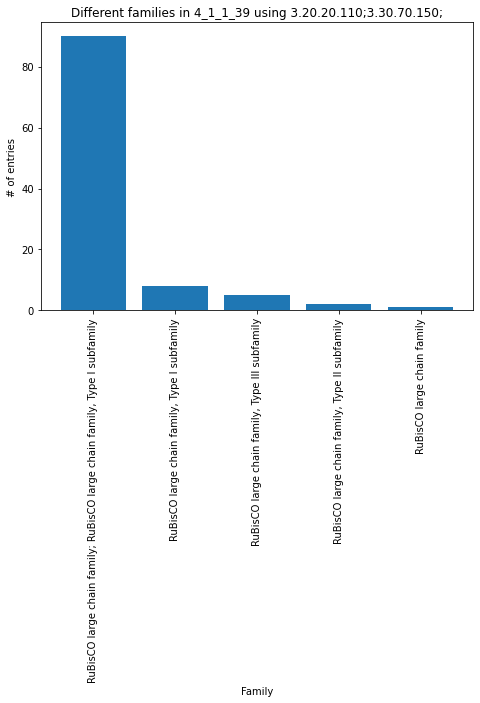

Would you like to choose another group? (Y/N): N
The number of entries in the Gene3D group are 106 

Cross_reference_OrthoDB
4_1_1_39 Cross_reference_OrthoDB: 9.65% of entries annotated


Compare entries to OrthoDB filtering? (Y/N): N
4_1_1_39: BRENDA_KM: 79.41% of entries annotated in IP
4_1_1_39: BRENDA_KM: 0.0% of entries annotated in SMART
4_1_1_39: BRENDA_KM: 76.42% of entries annotated in Gene3D


In [21]:
rub_filtered = generate_filtered_entries('4_1_1_39', 0.5, 'BRENDA_KM', 2)

In [24]:
calc_total_overlap(rub_filtered)

compare_overlap(rub_filtered, 'IP', 'SMART')

compare_overlap(rub_filtered, 'IP', 'Gene3D')

compare_overlap(rub_filtered, 'SMART', 'Gene3D')

IP: entries = 102
SMART: entries = 6
Gene3D: entries = 106
Total overlap between all groups 0 

IP: entries = 102
SMART: entries = 6
Total overlap between IP & SMART is 0

IP: entries = 102
Gene3D: entries = 106
Total overlap between IP & Gene3D is 102

SMART: entries = 6
Gene3D: entries = 106
Total overlap between SMART & Gene3D is 0



set()

# 2_5_1_18: glutathione transferase

BRENDA_KM
2_5_1_18 BRENDA_KM: 25.85% of entries annotated




/home/seb-porras/miniconda3/envs/expat_bench/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
/home/seb-porras/miniconda3/envs/expat_bench/lib/python3.7/site-packages/ipykernel_launcher.py:79: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


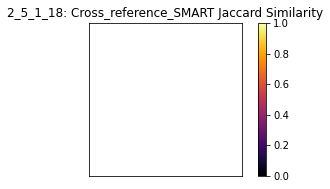

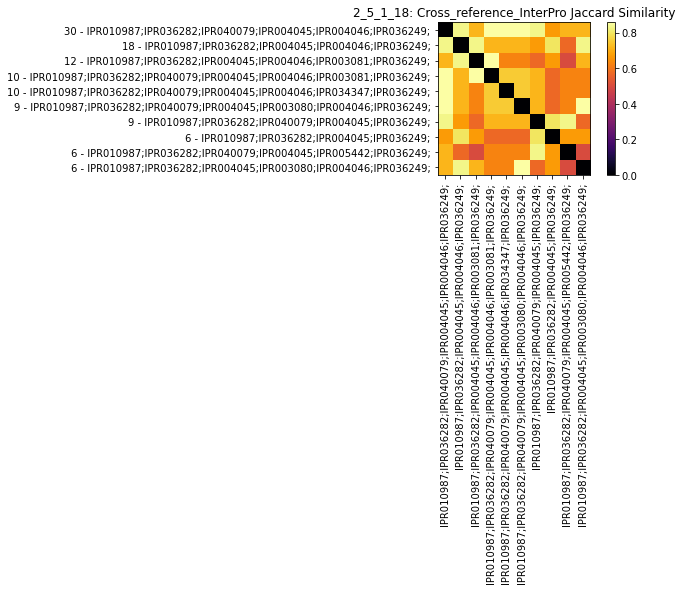

Choose a SMART row to grab entries from: 0
Choose a InterPro row to grab entries from: 0


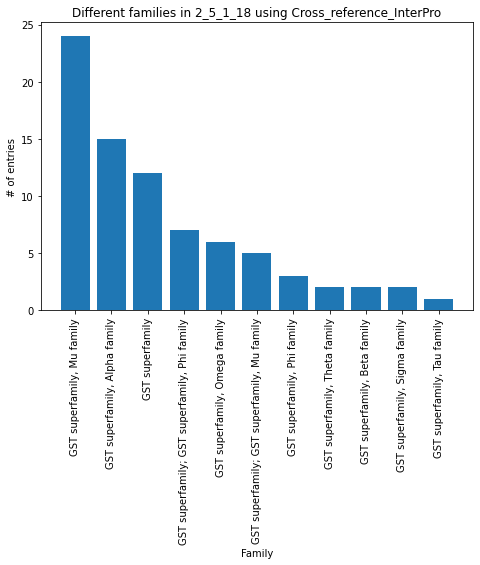

Happy with selection(Y/N): Y
Number of sequences after IP filtering = 110
Cross_reference_Gene3D
2_5_1_18 Cross_reference_Gene3D: 91.84% of entries annotated


Compare entries to gene3D filtering? (Y/N): Y
Cross_reference_Gene3D
3.40.30.10;               134
1.20.120.550;               1
dtype: int64
Enter a Gene3D tag: 3.40.30.10;


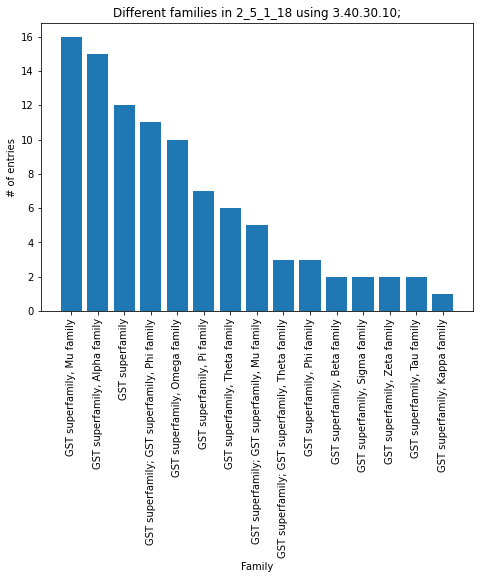

Would you like to choose another group? (Y/N): N
The number of entries in the Gene3D group are 134 

Cross_reference_OrthoDB
2_5_1_18 Cross_reference_OrthoDB: 38.1% of entries annotated


Compare entries to OrthoDB filtering? (Y/N): Y
Cross_reference_OrthoDB
1162336at2759;             28
1231780at2759;             15
1225872at2759;             10
1383885at2;                 1
1591261at2759;              1
990343at2759;               1
dtype: int64
Enter a OrthoDB tag: 1162336at2759;


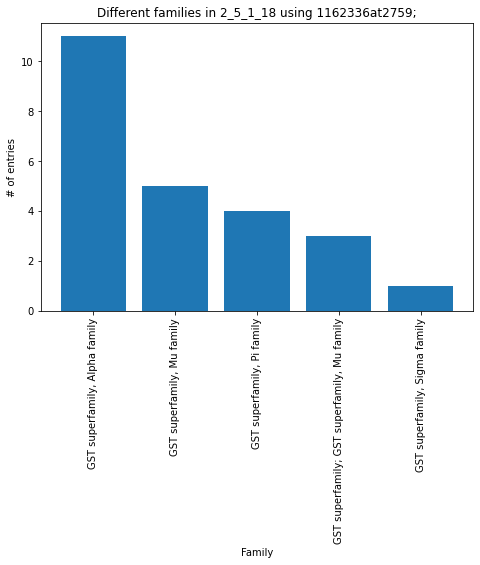

Would you like to choose another group? (Y/N): N
2_5_1_18: BRENDA_KM: 27.27% of entries annotated in IP
2_5_1_18: BRENDA_KM: 26.12% of entries annotated in Gene3D
2_5_1_18: BRENDA_KM: 10.71% of entries annotated in Ortho_DB


In [38]:
xylanase_filtered = generate_filtered_entries('2_5_1_18', 0.7, 'BRENDA_KM', 5)

In [44]:
a = calc_total_overlap(xylanase_filtered )

b = compare_overlap(xylanase_filtered, 'IP', 'Ortho_DB')

c = compare_overlap(xylanase_filtered, 'IP', 'Gene3D')

d = compare_overlap(xylanase_filtered, 'Ortho_DB', 'Gene3D')



IP: entries = 110
Gene3D: entries = 134
Ortho_DB: entries = 28
Total overlap between all groups 24 

IP: entries = 110
Ortho_DB: entries = 28
Total overlap between IP & Ortho_DB is 24

IP: entries = 110
Gene3D: entries = 134
Total overlap between IP & Gene3D is 102

Ortho_DB: entries = 28
Gene3D: entries = 134
Total overlap between Ortho_DB & Gene3D is 28



- Need to validate 

1) Look for trees that have been established and see if I can replicate a tree with similar topology 
2) Take a group of EC groups and see if I can filter down to the same group with similar accuracy 
3) Look at the similarity of the sequences that are coming through and check their sequence identities to see if there is any bias in the filtering that's occuring 

4) Could use Gabe's tree annot workflow to validate if the clustering is similar to what we would expect 
5) could work through the filtered list and run BLAST to find similar seqs 